**Exploring rainfall driven hydrographs with Landlab**

*This notebook was developed from code written by Jordan Adams and Nicole Gasparini, Tulane University.*

In this activity we will explore the importance of watershed shape and rainfall intensity on resulting hydrographs.

To clearly contrast landscape shape, this notebook uses two synthetic landscapes, or landscapes produced using a landscape evolution model. One landscape is square (length = width) and one is rectangular (length = 4*width). Both landscapes have a drainage area of 36 km2 and a cell size of 30 m.

Overland flow is modeled as a diffusive approximation of the shallow water equation. No infiltration is modeled. Rain falls on the landscape and flows downhill, driving overland flow and a hydrograph at every location on the landscape. In this notebook, we track the hydrograph at three points in the watershed.

More background on the model used here and the results presented can be found in:

Adams, J.M., Gasparini, N.M., Hobley, D.E., Tucker, G.E., Hutton, E.W., Nudurupati, S.S. and Istanbulluoglu, E., 2017. The Landlab v1. 0 OverlandFlow component: a Python tool for computing shallow-water flow across watersheds. Geoscientific Model Development.

In [ ]:
## Code Block 1

## only needed for plotting in a notebook.
import matplotlib as mpl
import matplotlib.pyplot as plt

## important necessary packages, including landlab
import pandas as pd
import numpy as np
##!pip install landlab
import landlab
from landlab import imshow_grid
from landlab.components import FlowAccumulator, OverlandFlow
from landlab.io import read_esri_ascii


basin_flag = "Square"  # 'Square' or Long'
storm_flag = "Base"  # 'Base' or'HigherIntensity'

## or 'LongerDuration'

## If the basin flag matches one of the two select basins,
## below will set the filename which to read the DEM from and
## the outlet link and upstream link to sample discharge values
## from for plotting.

if basin_flag == "Square":
    watershed_dem = "Square_TestBasin.asc"
    ## Reading in the DEM given the filename from above
    (rmg, z) = read_esri_ascii(watershed_dem, name="topographic__elevation")
    outlet_node_to_sample = 300
    outlet_link_to_sample = rmg.links_at_node[outlet_node_to_sample][3]
    upstream_node_to_sample = 28689
    upstream_link_to_sample = rmg.links_at_node[upstream_node_to_sample][3]
    midstream_node_to_sample = 9102
    midstream_link_to_sample = rmg.links_at_node[midstream_node_to_sample][3]
else:
    watershed_dem = "Long_TestBasin.asc"
    ## Reading in the DEM given the filename from above
    (rmg, z) = read_esri_ascii(watershed_dem, name="topographic__elevation")
    outlet_node_to_sample = 150
    outlet_link_to_sample = rmg.links_at_node[outlet_node_to_sample][3]
    upstream_node_to_sample = 33859
    upstream_link_to_sample = rmg.links_at_node[upstream_node_to_sample][3]
    midstream_node_to_sample = 14658
    midstream_link_to_sample = rmg.links_at_node[midstream_node_to_sample][2]

## The Flow Router calculates drainage area, which is helpful for
## calculating equilibrium discharge, which we illustrate later.
fr = FlowAccumulator(rmg)  # Instantiate flow router
fr.run_one_step()  # Drainage area calculated

In [ ]:
## Code Block 2: Now we set the boundary conditions, initialize the process components, and set the appropriate storm parameters.

## Set boundary coditions on the grid
rmg.set_watershed_boundary_condition(z)

## instantiate OverlandFlow object
rmg.add_zeros("surface_water__depth", at="node")
of = OverlandFlow(rmg, alpha=0.45, steep_slopes=True)

## Assign storm conditions based on flag in Code Block 2
if storm_flag == "Base":
    starting_precip_mmhr = 5.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10**-7)
    storm_duration = 7200.0
elif storm_flag == "HigherIntensity":
    starting_precip_mmhr = 10.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10**-7)
    storm_duration = 3600.0
elif storm_flag == "LongerDuration":
    starting_precip_mmhr = 2.5
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10**-7)
    storm_duration = 14400.0

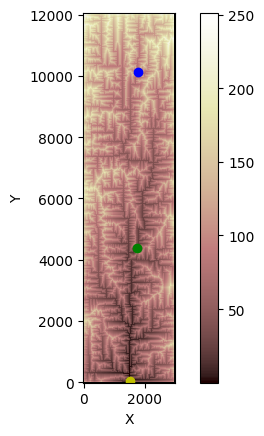

In [ ]:
## Code Block 3: Before we go further, let's pause to look at the landscape that we will be routing flow over.

plt.figure(1)
imshow_grid(rmg, z)  # plot the DEM
plt.plot(rmg.node_x[outlet_node_to_sample], rmg.node_y[outlet_node_to_sample], "yo")
plt.plot(rmg.node_x[upstream_node_to_sample], rmg.node_y[upstream_node_to_sample], "bo")
plt.plot(
    rmg.node_x[midstream_node_to_sample], rmg.node_y[midstream_node_to_sample], "go")

# New Section

In [ ]:
## Code Block 4: Initialize a few more parameters, and getting ready to run the time loop and save data for plotting.

elapsed_time = 1.0  # s
model_run_time = 43200.0  # s

## Lists for saving data
discharge_at_outlet = []
discharge_upstream = []
discharge_midstream = []
hydrograph_time = []

## Setting initial fields...
rmg["node"]["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)

In [ ]:
## Code Block 5: Now the time loop that generates overland flow.

while elapsed_time < model_run_time:
    # Setting the adaptive time step
    of.dt = of.calc_time_step()

    ## The storm starts when the model starts. While the elapsed time is less
    ## than the storm duration, we add water to the system as rainfall.
    if elapsed_time < (storm_duration):
        of.rainfall_intensity = starting_precip_ms
    else:  # elapsed time exceeds the storm duration, rainfall ceases.
        of.rainfall_intensity = 0.0

    of.run_one_step()  # Generating overland flow based on the deAlmeida solution.

    ## Append time and discharge to their lists to save data and for plotting.
    hydrograph_time.append(elapsed_time)
    q = rmg.at_link["surface_water__discharge"]
    discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * rmg.dx)
    discharge_upstream.append(np.abs(q[upstream_link_to_sample]) * rmg.dx)
    discharge_midstream.append(np.abs(q[midstream_link_to_sample]) * rmg.dx)

    ## output time every now and then so that you know the code
    ## is actually running
    if (elapsed_time % 100) < 2:
        print("elapsed time = ", elapsed_time)

    ## Updating elapsed_time
    elapsed_time += of.dt

elapsed time =  1.0
elapsed time =  3300.53338249
elapsed time =  3400.9313374
elapsed time =  5100.32703513
elapsed time =  5401.79437299
elapsed time =  5700.26414834
elapsed time =  6001.74678803
elapsed time =  6500.07540965
elapsed time =  6801.81565909
elapsed time =  7101.33827095
elapsed time =  7301.22291767
elapsed time =  8200.97670881
elapsed time =  8901.99265288
elapsed time =  9100.00898478
elapsed time =  9200.51727447
elapsed time =  9300.22677616
elapsed time =  9700.59023623
elapsed time =  10501.1989861
elapsed time =  10700.452119
elapsed time =  10900.0278503
elapsed time =  11001.5501979
elapsed time =  11101.3937535
elapsed time =  11501.5074993
elapsed time =  11901.6506546
elapsed time =  12000.4390994
elapsed time =  12401.6418325
elapsed time =  12700.3577993
elapsed time =  12800.8771078
elapsed time =  12901.0058028
elapsed time =  13000.7751086
elapsed time =  13100.2139091
elapsed time =  13401.8632771
elapsed time =  13500.0787034
elapsed time =  13700.

(0.0, 43190.143940786482, 0.0, 100.0)

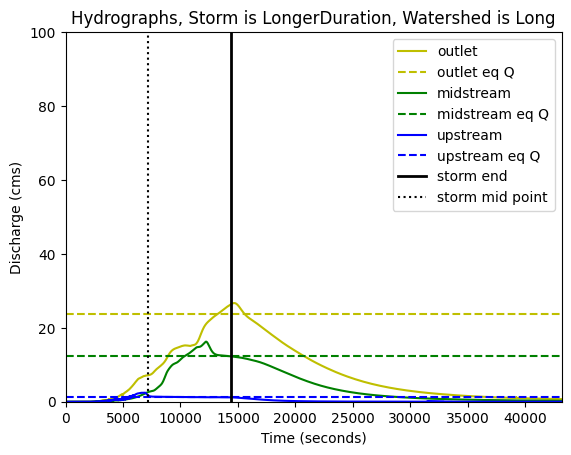

In [ ]:
## Code Block 6: Let's look at the data.

## Calculate equilibrium discharge at each point for reference
outlet_eq_q = starting_precip_ms * rmg.at_node["drainage_area"][outlet_node_to_sample]
midstream_eq_q = (
    starting_precip_ms * rmg.at_node["drainage_area"][midstream_node_to_sample]
)
upstream_eq_q = (
    starting_precip_ms * rmg.at_node["drainage_area"][upstream_node_to_sample]
)


## Plotting hydrographs and equilibrium discharge
plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "y-", label="outlet")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [outlet_eq_q, outlet_eq_q],
    "y--",
    label="outlet eq Q",
)
plt.plot(hydrograph_time, discharge_midstream, "g-", label="midstream")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [midstream_eq_q, midstream_eq_q],
    "g--",
    label="midstream eq Q",
)
plt.plot(hydrograph_time, discharge_upstream, "b-", label="upstream")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [upstream_eq_q, upstream_eq_q],
    "b--",
    label="upstream eq Q",
)

## Plot storm end and center of storm for reference
plt.plot(
    [storm_duration, storm_duration], [0, 100], "k-", linewidth=2, label="storm end"
)
plt.plot(
    [storm_duration / 2, storm_duration / 2], [0, 100], "k:", label="storm mid point"
)

plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
title_text = "Hydrographs, Storm is " + storm_flag + ", Watershed is " + basin_flag
plt.title(title_text)
plt.axis([0, np.max(hydrograph_time), 0, 100])

If you have reached this point, you should have produced a plot of three hydrographs from different points on the square watershed, produced from overland flow driven by the base storm.

There are four scenarios we will explore today: two different watersheds and two different storms. Run all four scenarios by systematically changing the basin_flag and storm_flag in Code Block 1 and rerunning all of the following code blocks sequentially.

**Save the hydrograph plots for each scenario. Include those plots in a document that also contains your typed answers to each of the questions below.

1. Consider only the two storms run on the square watershed. What aspects of the hydrograph change at the outlet as the storm gets more intense? Are there aspects of the outlet hydrograph that are not sensitive to the storm intensity? Do the midstream and upstream hydrographs exhibit the same sensitivity to storm intensity? If yes, why? If no, why not?

2. Now, consider only the two storms run on the long watershed. What aspects of the hydrograph change at the outlet as the storm gets more intense? Are there aspects of the outlet hydrograph that are not sensitive to the storm intensity? Do the midstream and upstream hydrographs exhibit the same sensitivity to storm intensity? If yes, why? If no, why not?

3. Now compare the results between the two different basin shapes. Compare only between similar points (e.g. square outlet to long outlet) and between the same storm characteristics. Does watershed shape affect hydrograph shape? If so, how? If so, does it impact all locations in the same manner? Do different storm charactersitics exaggerate the differences between the different watersheds?

Do the model results match your intuition? If not, do you think your intuition was wrong, or the model was wrong, or both? Remember, models are helpful for learning but they are highly simplified representations of the real world. Wihtout knowing the details of the model, does it seem like something is missing from your model results?

The End!